# CIFAR10

In [1]:
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
import gc
import lightning as L
import lightning.pytorch.callbacks as callbacks
import lightning.pytorch.loggers as loggers
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import torch.nn as nn
import yaml

gc.collect()
torch.cuda.empty_cache()

In [2]:
from model import SwinTransformer2D, SwinTransformerConfig2D
from notebooks.cifar10.reference import SwinTransformerReference2D

## Hyperparameters

In [3]:
batch_size = 128
num_epochs = 100
learning_rate=3e-4
weight_decay=0.05

## Data setup

In [4]:
transform_train = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
train_dataset = datasets.CIFAR10(root="notebooks/cifar10/.data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="notebooks/cifar10/.data", train=False, download=True, transform=transform_test)
train_dataset, val_dataset = random_split(train_dataset, [45000, 5000])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


## Model setup

In [6]:
class SwinModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.swin = SwinTransformer2D(config)
        self.norm = nn.LayerNorm(self.swin.out_channels[-1])
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten(1)
        self.fc = nn.Linear(self.swin.out_channels[-1], 10)

    def forward(self, x):
        out = self.swin(x)
        x = out[-1]
        x = self.norm(x)
        x = self.avgpool(x.transpose(1, 2))
        x = self.flatten(x)
        x = self.fc(x)
        return x

model_a = SwinModel(SwinTransformerConfig2D(
    input_size=(32, 32),
    in_channels=3,
    embed_dim=32,
    num_blocks=[2, 4, 4, 2],
    patch_window_size=[(2, 2)] * 4,
    block_window_size=([(4, 4)] * 3) + [(2, 2)],
    num_heads=[2, 4, 8, 16],
    drop_path=0.1,
))

model_b = SwinTransformerReference2D(
    num_classes=10,
    img_size=32,
    in_chans=3,
    embed_dim=32,
    depths=[2, 4, 4, 2],
    patch_size=2,
    window_size=4,
    num_heads=[2, 4, 8, 16],
)

In [7]:

class SwinTransformerClf(L.LightningModule):
    def __init__(self, model, name, max_epochs=100, steps_per_epoch=300, learning_rate=3e-4, weight_decay=0.05):
        super().__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        self.steps_per_epoch = steps_per_epoch
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.name = name
        self.model = model
        self.save_hyperparameters(ignore=["model"])

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, _):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y == y_hat.argmax(dim=1)).float().mean()
        self.log_dict(
            {"train_loss": loss, "train_acc": acc},
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            sync_dist=True,
        )
        return loss

    def validation_step(self, batch, _):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y == y_hat.argmax(dim=1)).float().mean()
        self.log_dict(
            {"val_loss": loss, "val_acc": acc},
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            sync_dist=True,
        )
        return loss

    def test_step(self, batch, _):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y == y_hat.argmax(dim=1)).float().mean()
        self.log_dict(
            {"test_loss": loss, "test_acc": acc},
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            sync_dist=True,
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=self.learning_rate, epochs=self.max_epochs, steps_per_epoch=self.steps_per_epoch
        )
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "step"}}

In [8]:
model_a = SwinTransformerClf(
    model_a,
    "custom",
    max_epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    learning_rate=learning_rate,
    weight_decay=weight_decay,
)
print(summary(model_a, input_size=(batch_size, 3, 32, 32)))

model_b = SwinTransformerClf(
    model_b,
    "reference",
    max_epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    learning_rate=learning_rate,
    weight_decay=weight_decay,
)
summary(model_b, input_size=(batch_size, 3, 32, 32))



Layer (type:depth-idx)                                            Output Shape              Param #
SwinTransformerClf                                                [128, 10]                 --
├─SwinModel: 1-1                                                  [128, 10]                 --
│    └─SwinTransformer2D: 2-1                                     [128, 256, 32]            --
│    │    └─ModuleDict: 3-1                                       --                        2,771,320
│    └─LayerNorm: 2-2                                             [128, 4, 256]             512
│    └─AdaptiveAvgPool1d: 2-3                                     [128, 256, 1]             --
│    └─Flatten: 2-4                                               [128, 256]                --
│    └─Linear: 2-5                                                [128, 10]                 2,570
Total params: 2,774,402
Trainable params: 2,774,402
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 589.87
Input size 

Layer (type:depth-idx)                                  Output Shape              Param #
SwinTransformerClf                                      [128, 10]                 --
├─SwinTransformerReference2D: 1-1                       [128, 10]                 --
│    └─PatchEmbed: 2-1                                  [128, 256, 32]            --
│    │    └─Conv2d: 3-1                                 [128, 32, 16, 16]         416
│    │    └─LayerNorm: 3-2                              [128, 256, 32]            64
│    └─Dropout: 2-2                                     [128, 256, 32]            --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─BasicLayer: 3-3                             [128, 64, 64]             34,052
│    │    └─BasicLayer: 3-4                             [128, 16, 128]            234,000
│    │    └─BasicLayer: 3-5                             [128, 4, 256]             926,752
│    │    └─BasicLayer: 3-6                  

## Model training

In [9]:
for model in [model_a, model_b]:
    gc.collect()
    torch.cuda.empty_cache()
    
    L.seed_everything(42)

    csv_logger = loggers.CSVLogger("./notebooks/cifar10/logs", name=model.name)
    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10)
    learning_rate_monitor = callbacks.LearningRateMonitor(logging_interval="epoch")
    model_checkpoint = callbacks.ModelCheckpoint(
        monitor="val_acc",
        dirpath="./checkpoints",
        filename=model.name,
        save_top_k=1,
        mode="max",
    )

    trainer = L.Trainer(
        max_epochs=num_epochs,
        logger=csv_logger,
        callbacks=[early_stopping, learning_rate_monitor, model_checkpoint],
        gradient_clip_val=1.0,
        precision="16-mixed",
    )
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(model=model, dataloaders=test_loader)

Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/temple/Repositories/swin/.venv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/temple/Repositories/swin/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | model     | SwinModel        | 2.8 M  | train
-------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.098    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.840499997138977
        test_loss           0.8831820487976074
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                       | Params | Mode 
-----------------------------------------------------------------
0 | criterion | CrossEntropyLoss           | 0      | train
1 | model     | SwinTransformerReference2D | 2.8 M  | train
-----------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.113    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8263000249862671
        test_loss            0.920045018196106
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Analysis

Hyperparameters:
   learning_rate: 0.0003
   max_epochs: 100
   name: custom
   steps_per_epoch: 352
   weight_decay: 0.05
Hyperparameters:
   learning_rate: 0.0003
   max_epochs: 100
   name: reference
   steps_per_epoch: 352
   weight_decay: 0.05


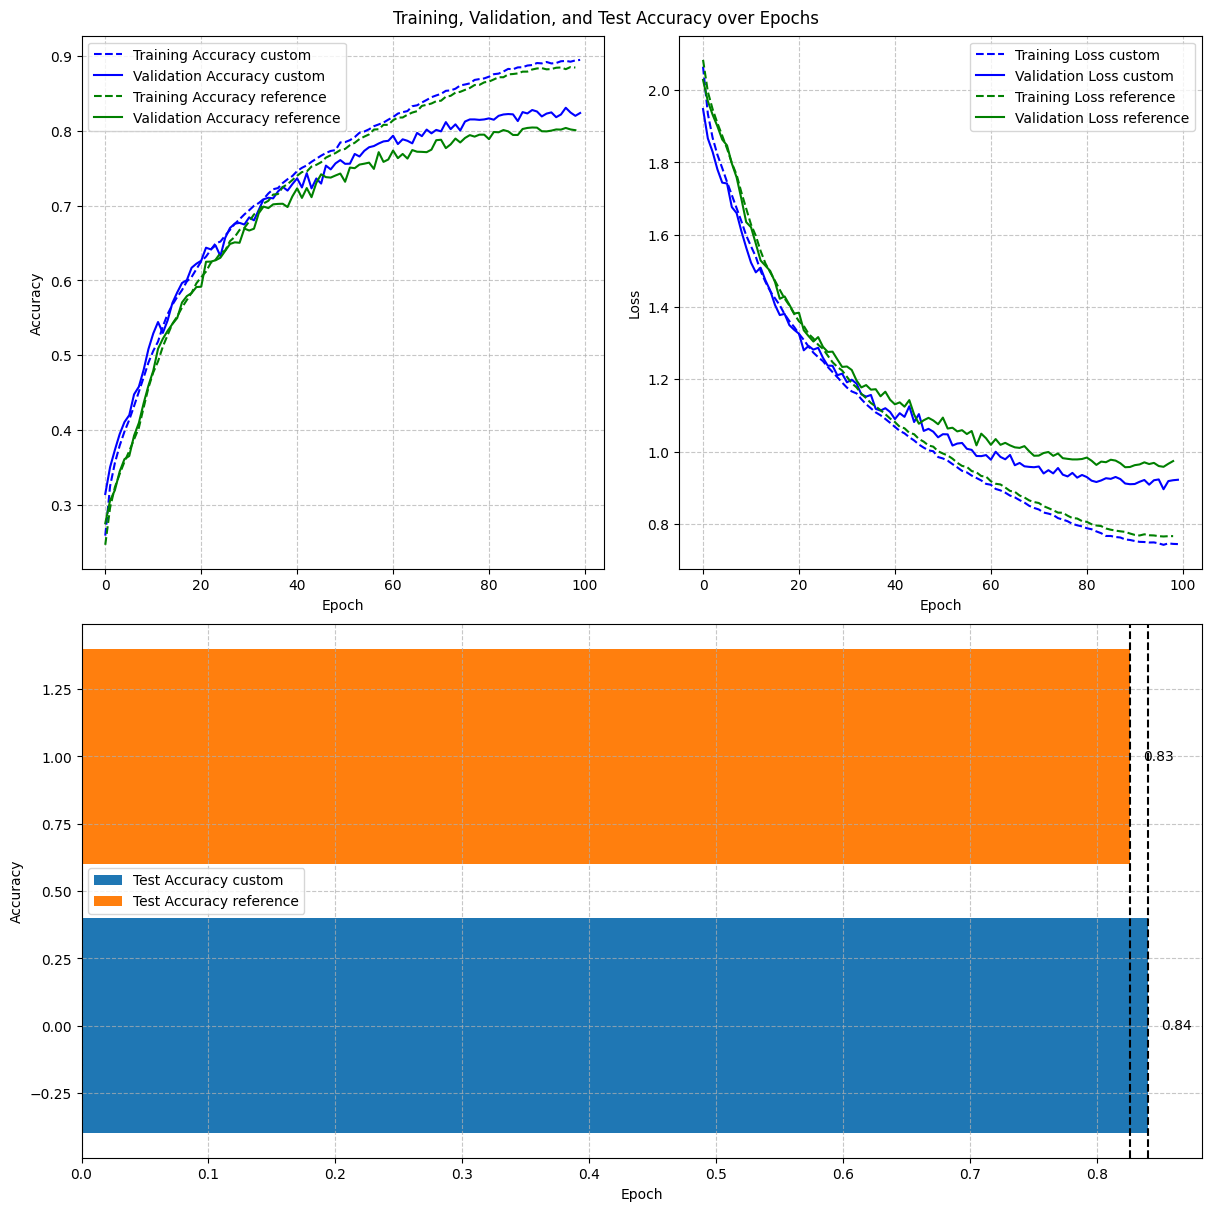

In [15]:
LOGS_PATH = "./notebooks/cifar10/logs"

model_logs = [os.path.join(LOGS_PATH, f) for f in os.listdir(LOGS_PATH)]
model_versions = [[os.path.join(f, v) for v in os.listdir(f)] for f in model_logs]
model_versions_latest = [max(v, key=os.path.getctime) for v in model_versions]
model_csvs = [os.path.join(v, "metrics.csv") for v in model_versions_latest]
model_hparams = [os.path.join(v, "hparams.yaml") for v in model_versions_latest]

fig = plt.figure(constrained_layout=True, figsize=(12, 12), dpi=100)
fig.suptitle("Training, Validation, and Test Accuracy over Epochs")

gs = fig.add_gridspec(2, 2)
ax_acc = fig.add_subplot(gs[0, 0])
ax_loss = fig.add_subplot(gs[0, 1])
ax_test = fig.add_subplot(gs[1, :])

for i, (csv, hparams) in enumerate(zip(model_csvs, model_hparams)):
    with open(hparams, "r") as file:
        hparams = yaml.safe_load(file)

    print("Hyperparameters:")
    for key, value in hparams.items():
        print(f"   {key}: {value}")

    df = pd.read_csv(csv)
    df["epoch"] = df["step"] // hparams["steps_per_epoch"]
    col = list(mcolors.BASE_COLORS.keys())[i]

    train_data = df[df["train_acc_epoch"].notna()]
    val_data = df[df["val_acc"].notna()]
    ax_acc.plot(
        train_data["epoch"],
        train_data["train_acc_epoch"],
        label=f"Training Accuracy {hparams['name']}",
        color=col,
        linestyle="--",
    )
    ax_acc.plot(
        val_data["epoch"],
        val_data["val_acc"],
        label=f"Validation Accuracy {hparams['name']}",
        color=col,
        linestyle="-",
    )
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.legend()
    ax_acc.grid(True, linestyle="--", alpha=0.7)

    train_data = df[df["train_loss_epoch"].notna()]
    val_data = df[df["val_loss"].notna()]
    ax_loss.plot(
        train_data["epoch"],
        train_data["train_loss_epoch"],
        label=f"Training Loss {hparams['name']}",
        color=col,
        linestyle="--",
    )
    ax_loss.plot(
        val_data["epoch"],
        val_data["val_loss"],
        label=f"Validation Loss {hparams['name']}",
        color=col,
        linestyle="-",
    )
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()
    ax_loss.grid(True, linestyle="--", alpha=0.7)

    test_data = df[df["test_acc"].notna()]

    ax_test.barh(i, test_data["test_acc"], label=f"Test Accuracy {hparams['name']}")
    ax_test.set_xlabel("Epoch")
    ax_test.set_ylabel("Accuracy")
    ax_test.legend()
    ax_test.grid(True, linestyle="--", alpha=0.7)
    ax_test.axvline(test_data["test_acc"].max(), color="black", linestyle="--")
    ax_test.text(
        test_data["test_acc"].max() + 0.01,
        i,
        f"{test_data['test_acc'].max():.2f}",
        va="center",
        ha="left",
    )

plt.show()
plt.close()